[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/044_cnn_transfer_learning/cnn_transfer_learning.ipynb)

# Transfer Learning en Redes Convolucionales

En posts anteriores hemos introducido la arquitectura de `red neuronal convolucional` y también hemos presentado varias arquitecturas famosas que han demostrado buenas prestaciones en multitud de tareas. Estas redes están formadas muchas capas convolucionales, algunas con más de 100 capas, lo cual significa que tienen muchos parámetros y entrenarlas desde cero puedes ser costoso. Sin embargo, existe una técnica que nos permite obtener buenos modelos con menores requisitos: el *transfer learning*. Ya hemos hablado anteriormente de esta técnica, en el contexto de modelos de lenguaje, pero la idea es la misma: utilizaremos el máximo número de capas de una red ya entrenada en otro dataset, y simplemente entrenaremos las nuevas capas que necesitemos para nuestra tarea concreta.

![](https://pennylane.ai/qml/_images/transfer_learning_general.png)

En este post vamos a ver cómo podemos utilizar una red neuronal pre-entrada en Imagenet, y adaptarla para una nueva tarea de clasificación con un pequeño dataset.

## El dataset

Nuestro objetivo será el de entrenar un clasificador de flores. Podemos descargar las imágenes de la siguiente url.

In [1]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle


In [2]:
from google.colab import files
files.upload()
files

Saving kaggle.json to kaggle.json


<module 'google.colab.files' from '/usr/local/lib/python3.9/dist-packages/google/colab/files.py'>

In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d utkarshsaxenadn/shoes-classification-dataset-13k-images

 99% 274M/276M [00:15<00:00, 19.0MB/s]
100% 276M/276M [00:15<00:00, 18.3MB/s]


In [5]:
import zipfile

with zipfile.ZipFile('/content/shoes-classification-dataset-13k-images.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [6]:
import os 

import cv2
from tqdm import tqdm

PATH = '/content/Shoes Dataset/Train'
classes = os.listdir(PATH)
classes

['Ballet Flat', 'Boat', 'Clog', 'Brogue', 'Sneaker']

Una vez extraído el dataset, podemos ver que tenemos 5 clases de flores diferentes, distribuidas en 5 carpetas diferentes. Cada carpeta contiene varios ejemplos de flores de la categoría en cuestión.

In [7]:
imgs, labels = [], []

for i, lab in enumerate(classes):
    paths = [p for p in os.listdir(f'{PATH}/{lab}') if p.endswith('.jpeg') or p.endswith('.png')]
    print(f'Categoría: {lab}. Imágenes: {len(paths)}')
    imgs += [os.path.join(PATH, lab, img) for img in paths]
    labels += [i]*len(paths)

print(f'Total de imágenes: {len(imgs)}')
imgs[:5]

Categoría: Ballet Flat. Imágenes: 2000
Categoría: Boat. Imágenes: 2000
Categoría: Clog. Imágenes: 2000
Categoría: Brogue. Imágenes: 2000
Categoría: Sneaker. Imágenes: 2000
Total de imágenes: 10000


['/content/Shoes Dataset/Train/Ballet Flat/Ballet Flat-Train (48).jpeg',
 '/content/Shoes Dataset/Train/Ballet Flat/Ballet Flat-Train (1786).jpeg',
 '/content/Shoes Dataset/Train/Ballet Flat/Ballet Flat-Train (566).jpeg',
 '/content/Shoes Dataset/Train/Ballet Flat/Ballet Flat-Train (722).jpeg',
 '/content/Shoes Dataset/Train/Ballet Flat/Ballet Flat-Train (1696).jpeg']

In [8]:
len(imgs)

10000

Podemos visualizar algunas imágenes en el dataset.

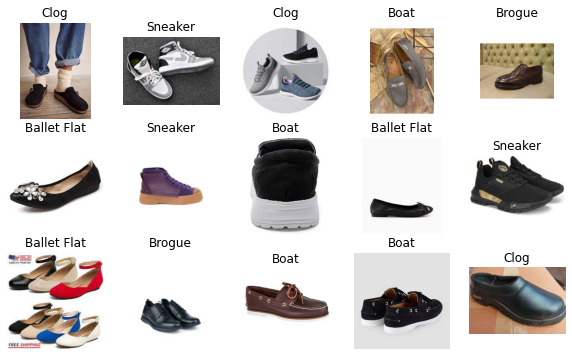

In [9]:
import random 
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(imgs)-1)
    img = io.imread(imgs[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(classes[labels[ix]])
plt.show()

Vamos a crear también un subconjunto de test para poder comparar varios modelos.

In [10]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.2, stratify=labels)

len(train_imgs), len(test_imgs)


(8000, 2000)

Y por último creamos nuestros objetos `Dataset` y `DataLoader` para poder darle las imágenes a nuestros modelos.

In [11]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
from skimage import color
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, trans, device):
    self.X = X
    self.y = y
    self.trans = trans
    self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    # cargar la imágen
    img = io.imread(self.X[ix])
    #hacemos que nuestras imagenes sena de 3 dimensiones 
    #borra la transparencia
    if img.shape[2] == 4:
      img= color.rgba2rgb(img)
    
      
    # aplicar transformaciones
    #print(f"imagen: {img}")
    if self.trans:
      img = self.trans(image=img)["image"]
    return torch.from_numpy(img / 255.).float().permute(2,0,1), torch.tensor(self.y[ix])

In [12]:
img.shape

(174, 250, 3)

Nos aseguraremos que todas las imágenes del dataset tengan las mismas dimensiones: 224x224 píxeles.

In [13]:
import albumentations as A

trans = A.Compose([
    A.Resize(224, 224)
])

dataset = {
    'train': Dataset(train_imgs, train_labels, trans, device), 
    'test': Dataset(test_imgs, test_labels, trans, device)
}

len(dataset['train']), len(dataset['test'])

(8000, 2000)

In [14]:
dataset['train'][2]

(tensor([[[0.7804, 0.7765, 0.7765,  ..., 0.7490, 0.7647, 0.7647],
          [0.4941, 0.5020, 0.5137,  ..., 0.7451, 0.7412, 0.7451],
          [0.4431, 0.4471, 0.4588,  ..., 0.7255, 0.7333, 0.7333],
          ...,
          [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[0.6667, 0.6627, 0.6627,  ..., 0.6039, 0.6196, 0.6196],
          [0.3804, 0.3882, 0.4000,  ..., 0.6000, 0.6000, 0.6000],
          [0.3294, 0.3333, 0.3451,  ..., 0.5804, 0.5882, 0.5882],
          ...,
          [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[0.5020, 0.4980, 0.4980,  ..., 0.3882, 0.4039, 0.4039],
          [0.2157, 0.2235, 0.2353,  ..., 0.3882, 0.3804, 0.3843],
          [0.1647, 0.1686, 0.1804,  ...,

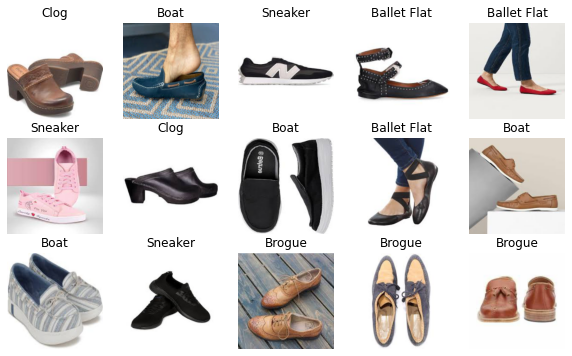

In [15]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['train'])-1)
    img, lab = dataset['train'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

In [16]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True), 
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape

torch.Size([64, 3, 224, 224])

## El Modelo

Vamos a escoger la arquitectura `resnet`, de la que ya hablamos en el post anterior, para hacer nuestro clasificador. De este modelo usarmos todas las capas excepto la última, la cual sustituiremos por una nueva capa lineal para llevar a cabo la clasificación en 5 clases.

In [17]:
import torchvision

resnet = torchvision.models.resnet18()
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
class ModelCustom(torch.nn.Module):
  def __init__(self, n_outputs=5, pretrained=False, freeze=False):
    super().__init__()
    # descargamos resnet
    resnet = torchvision.models.resnet18(pretrained=pretrained)
    # nos quedamos con todas las capas menos la última
    self.resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
    if freeze:
      for param in self.resnet.parameters():
        param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = torch.nn.Linear(512, 5)

  def forward(self, x):
    x = self.resnet(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

  def unfreeze(self):
    for param in self.resnet.parameters():
        param.requires_grad=True

In [19]:
model_custom = ModelCustom()
outputs = model_custom(torch.randn(64, 3, 224, 224))
outputs.shape


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([64, 5])

In [20]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

### Entrenando desde cero

En primer lugar vamos a entrenar nuestro modelo desde cero para ver qué métricas podemos obtener.

In [21]:
model_c = ModelCustom()
fit(model_c, dataloader, epochs=15)

val_loss 1.83265 val_acc 0.26232: 100%|██████████| 8/8 [00:07<00:00,  1.14it/s]


Epoch 1/15 loss 1.54390 val_loss 1.83265 acc 0.29437 val_acc 0.26232


val_loss 1.47048 val_acc 0.33631: 100%|██████████| 8/8 [00:06<00:00,  1.19it/s]


Epoch 2/15 loss 1.44754 val_loss 1.47048 acc 0.37200 val_acc 0.33631


val_loss 1.48997 val_acc 0.34183: 100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Epoch 3/15 loss 1.37741 val_loss 1.48997 acc 0.41975 val_acc 0.34183


val_loss 2.41518 val_acc 0.28730: 100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Epoch 4/15 loss 1.30615 val_loss 2.41518 acc 0.47113 val_acc 0.28730


val_loss 1.87843 val_acc 0.32238: 100%|██████████| 8/8 [00:06<00:00,  1.17it/s]


Epoch 5/15 loss 1.23599 val_loss 1.87843 acc 0.50575 val_acc 0.32238


val_loss 2.27766 val_acc 0.29154: 100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


Epoch 6/15 loss 1.16324 val_loss 2.27766 acc 0.54863 val_acc 0.29154


val_loss 2.38054 val_acc 0.34905: 100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Epoch 7/15 loss 1.09120 val_loss 2.38054 acc 0.57550 val_acc 0.34905


val_loss 1.35235 val_acc 0.44047: 100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


Epoch 8/15 loss 1.01155 val_loss 1.35235 acc 0.61638 val_acc 0.44047


val_loss 1.21581 val_acc 0.52817: 100%|██████████| 8/8 [00:06<00:00,  1.17it/s]


Epoch 9/15 loss 0.94163 val_loss 1.21581 acc 0.64275 val_acc 0.52817


val_loss 1.18149 val_acc 0.55303: 100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


Epoch 10/15 loss 0.84875 val_loss 1.18149 acc 0.68137 val_acc 0.55303


val_loss 1.70061 val_acc 0.45996: 100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


Epoch 11/15 loss 0.76554 val_loss 1.70061 acc 0.72925 val_acc 0.45996


val_loss 1.61728 val_acc 0.50695: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Epoch 12/15 loss 0.65658 val_loss 1.61728 acc 0.77275 val_acc 0.50695


val_loss 1.83969 val_acc 0.44712: 100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


Epoch 13/15 loss 0.54958 val_loss 1.83969 acc 0.81200 val_acc 0.44712


val_loss 1.45400 val_acc 0.51829: 100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


Epoch 14/15 loss 0.43882 val_loss 1.45400 acc 0.85725 val_acc 0.51829


val_loss 3.42297 val_acc 0.29894: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]

Epoch 15/15 loss 0.33048 val_loss 3.42297 acc 0.90038 val_acc 0.29894


In [22]:
import matplotlib.pyplot as plt

def plot_predictions(model, dataloader, r, c):
    model.to('cuda')
    with torch.no_grad():
        for loader_name, test_loader in dataloader.items():
            if loader_name == 'train':
                continue
            # Mostrar las primeras imágenes del primer lote del DataLoader de prueba
            fig = plt.figure(figsize=(2*c, 2*r))
            for batch_idx, (data, target) in enumerate(test_loader):
                if batch_idx == 0:
                    data = data.to('cuda')
                    target = target.to('cuda')
                    output = model(data)
                    predictions = output.argmax(dim=1)
                    for i in range(r * c):
                        plt.subplot(r, c, i + 1)
                        img = data[i].cpu().numpy().transpose(1, 2, 0)
                        y_true = target[i].item()
                        y_pred = predictions[i].item()
                        plt.imshow(img, cmap='gray')
                        plt.axis("off")
                        #plt.title(f"{y_true}/{y_pred}", color="green" if y_true == y_pred else "red")
                        plt.title(f"{classes[y_true]}/{classes[y_pred]}", color="green" if y_true == y_pred else "red")
                        plt.tight_layout()
                    plt.show()
                    break

In [23]:
# guardar modelo
PATH = './checkpoint_01.pt'
torch.save(model_c.state_dict(), PATH) 

In [24]:
# cargar modelo
model_cero = ModelCustom()
model_cero.load_state_dict(torch.load(PATH))
model_cero.eval()

ModelCustom(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

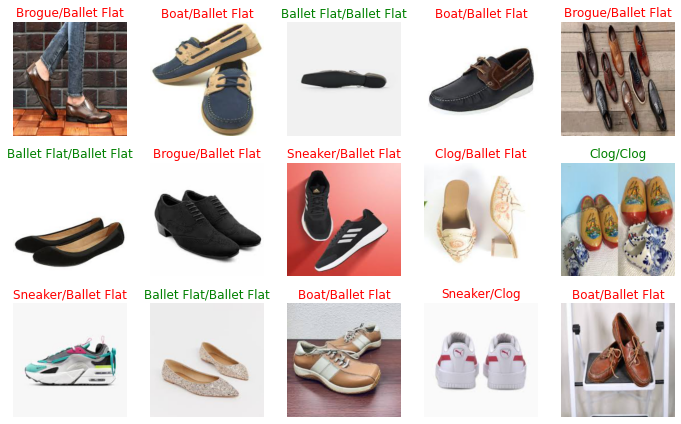

In [25]:
plot_predictions(model_cero, dataloader, 3, 5)

In [ ]:
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f838050af10>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f838050a220>}

Como puedes ver es complicado conseguir buenas métricas ya que nuestro dataset es muy pequeño.

## Transfer Learning

Ahora vamos a entrenar el mismo caso pero, en este caso, utilizando los pesos pre-entrenados de `resnet`.

In [26]:
model_c = ModelCustom(pretrained=True, freeze=True)
fit(model_c, dataloader)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

val_loss 0.91890 val_acc 0.69298: 100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


Epoch 1/5 loss 1.17193 val_loss 0.91890 acc 0.56725 val_acc 0.69298


val_loss 0.78090 val_acc 0.73501: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Epoch 2/5 loss 0.86274 val_loss 0.78090 acc 0.70875 val_acc 0.73501


val_loss 0.74028 val_acc 0.75218: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Epoch 3/5 loss 0.77810 val_loss 0.74028 acc 0.73225 val_acc 0.75218


val_loss 0.71156 val_acc 0.75331: 100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


Epoch 4/5 loss 0.73969 val_loss 0.71156 acc 0.74162 val_acc 0.75331


val_loss 0.69370 val_acc 0.75793: 100%|██████████| 8/8 [00:06<00:00,  1.23it/s]

Epoch 5/5 loss 0.71149 val_loss 0.69370 acc 0.75575 val_acc 0.75793


In [27]:
# guardar modelo
PATH = './checkpoint_Transfer_Learning.pt'
torch.save(model_c.state_dict(), PATH)

In [28]:
# cargar modelo
model_Transfer = ModelCustom()
model_Transfer.load_state_dict(torch.load(PATH))
model_Transfer.eval()

ModelCustom(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

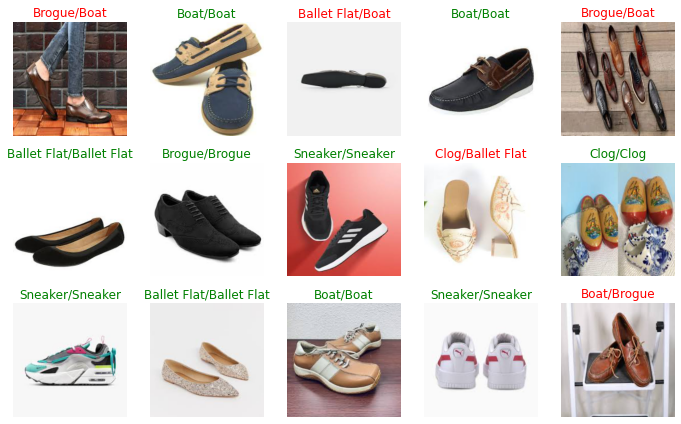

In [29]:
plot_predictions(model_c, dataloader, 3, 5)

Como puedes ver no sólo obtenemos un mejor modelo en menos *epochs* sino que además cada *epoch* tarda menos en completarse. Esto es debido a que, al no estar entrenando gran parte de la red, los requisitos computacionales se reducen considerablemente. Mejores modelos y entrenados más rápido.

## Fine Tuning

Todavía podemos mejorar un poco más si, además de utilizar los pesos descargados de Imagenet en `resnet`, entrenamos también la red completa.

In [30]:
model_c = ModelCustom(pretrained=True, freeze=False)
fit(model_c, dataloader)

val_loss 0.59197 val_acc 0.80739: 100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


Epoch 1/5 loss 0.88833 val_loss 0.59197 acc 0.68788 val_acc 0.80739


val_loss 0.51695 val_acc 0.83335: 100%|██████████| 8/8 [00:06<00:00,  1.14it/s]


Epoch 2/5 loss 0.46578 val_loss 0.51695 acc 0.84762 val_acc 0.83335


val_loss 0.44299 val_acc 0.84544: 100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Epoch 3/5 loss 0.32705 val_loss 0.44299 acc 0.90063 val_acc 0.84544


val_loss 0.41994 val_acc 0.86685: 100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Epoch 4/5 loss 0.22875 val_loss 0.41994 acc 0.93375 val_acc 0.86685


val_loss 0.41309 val_acc 0.87635: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]

Epoch 5/5 loss 0.15684 val_loss 0.41309 acc 0.95825 val_acc 0.87635


In [31]:
# guardar modelo
PATH = './checkpoint_Fine_tuning.pt'
torch.save(model_c.state_dict(), PATH) 


In [32]:
# cargar modelo
model_Fine_tuning= ModelCustom()
model_Fine_tuning.load_state_dict(torch.load(PATH))
model_Fine_tuning.eval()

ModelCustom(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

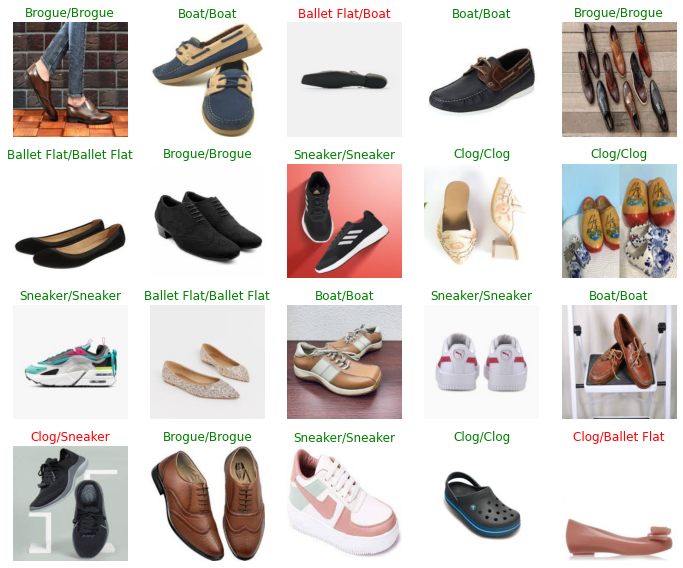

In [34]:
plot_predictions(model_Fine_tuning, dataloader, 4, 5)

Es común entrenar primero el modelo sin entrenar la red pre-entrenada durante varias epochs y después seguir entrenando, pero permitiendo ahora la actualización de pesos también en la red pre-entrenada (usualmente con un *learning rate* más pequeño).

In [35]:
model_o = ModelCustom(pretrained=True, freeze=True)
fit(model_o, dataloader)
model_o.unfreeze()
fit(model_o, dataloader, lr=1e-4)

val_loss 0.90372 val_acc 0.70065: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


Epoch 1/5 loss 1.16706 val_loss 0.90372 acc 0.57112 val_acc 0.70065


val_loss 0.78664 val_acc 0.73719: 100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


Epoch 2/5 loss 0.86642 val_loss 0.78664 acc 0.70813 val_acc 0.73719


val_loss 0.74349 val_acc 0.74361: 100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Epoch 3/5 loss 0.77993 val_loss 0.74349 acc 0.73137 val_acc 0.74361


val_loss 0.72814 val_acc 0.74786: 100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


Epoch 4/5 loss 0.73899 val_loss 0.72814 acc 0.74762 val_acc 0.74786


val_loss 0.69846 val_acc 0.75417: 100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


Epoch 5/5 loss 0.71291 val_loss 0.69846 acc 0.75587 val_acc 0.75417


val_loss 0.68542 val_acc 0.76345: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Epoch 1/5 loss 0.68282 val_loss 0.68542 acc 0.76638 val_acc 0.76345


val_loss 0.67708 val_acc 0.76540: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Epoch 2/5 loss 0.67181 val_loss 0.67708 acc 0.77375 val_acc 0.76540


val_loss 0.67185 val_acc 0.76454: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Epoch 3/5 loss 0.66165 val_loss 0.67185 acc 0.77612 val_acc 0.76454


val_loss 0.66395 val_acc 0.77073: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Epoch 4/5 loss 0.65032 val_loss 0.66395 acc 0.78100 val_acc 0.77073


val_loss 0.65978 val_acc 0.77235: 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]

Epoch 5/5 loss 0.64972 val_loss 0.65978 acc 0.78125 val_acc 0.77235


In [36]:
# guardar modelo
PATH = './checkpoint_dos_Formas.pt'
torch.save(model_o.state_dict(), PATH) 


In [37]:
# cargar modelo
model_o= ModelCustom()
model_o.load_state_dict(torch.load(PATH))


<All keys matched successfully>

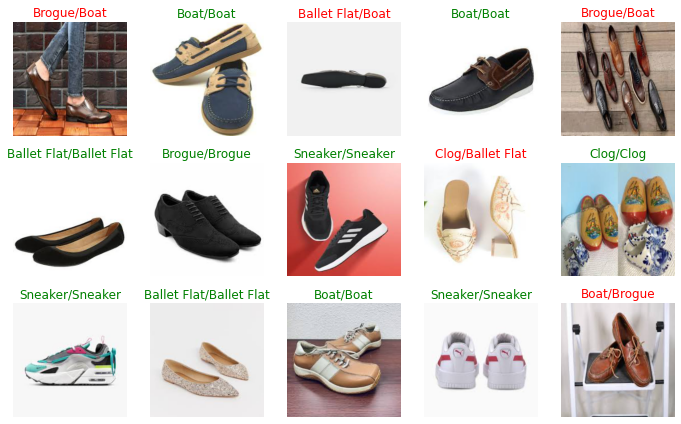

In [38]:
plot_predictions(model_o, dataloader, 3, 5)

Otra alternativa de *fine tuning* es la de entrenar el modelo con diferentes *learning rates*, uno para la red pre-entrenada y otro para las capas nuevas.

In [39]:
optimizer = torch.optim.Adam([
    {'params': model_o.resnet.parameters(), 'lr': 1e-4},
    {'params': model_o.fc.parameters(), 'lr': 1e-3}
])

In [40]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr_resnet=1e-4, lr_fc=1e-3):
    model.to(device)
    optimizer = optimizer = torch.optim.Adam([{'params': model.resnet.parameters(), 'lr': lr_resnet},{'params': model.fc.parameters(), 'lr': lr_fc}])
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [41]:
model_o = ModelCustom(pretrained=True, freeze=True)
fit(model_o, dataloader, lr_resnet=1e-4, lr_fc=1e-3)
model_o.unfreeze()
fit(model_o, dataloader, lr_resnet=1e-4, lr_fc=1e-3)

val_loss 0.81865 val_acc 0.72818: 100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


Epoch 1/5 loss 1.09548 val_loss 0.81865 acc 0.59350 val_acc 0.72818


val_loss 0.72492 val_acc 0.75353: 100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


Epoch 2/5 loss 0.80113 val_loss 0.72492 acc 0.71962 val_acc 0.75353


val_loss 0.68872 val_acc 0.75793: 100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


Epoch 3/5 loss 0.73093 val_loss 0.68872 acc 0.74450 val_acc 0.75793


val_loss 0.67076 val_acc 0.76390: 100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


Epoch 4/5 loss 0.69115 val_loss 0.67076 acc 0.76238 val_acc 0.76390


val_loss 0.68428 val_acc 0.75710: 100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


Epoch 5/5 loss 0.67909 val_loss 0.68428 acc 0.76400 val_acc 0.75710


val_loss 0.51265 val_acc 0.83541: 100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


Epoch 1/5 loss 0.51428 val_loss 0.51265 acc 0.82737 val_acc 0.83541


val_loss 0.45667 val_acc 0.86745: 100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


Epoch 2/5 loss 0.11045 val_loss 0.45667 acc 0.96875 val_acc 0.86745


val_loss 0.44691 val_acc 0.89498: 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Epoch 3/5 loss 0.02567 val_loss 0.44691 acc 0.99550 val_acc 0.89498


val_loss 0.46921 val_acc 0.89100: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Epoch 4/5 loss 0.00753 val_loss 0.46921 acc 0.99962 val_acc 0.89100


val_loss 0.46436 val_acc 0.89340: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]

Epoch 5/5 loss 0.00416 val_loss 0.46436 acc 0.99962 val_acc 0.89340


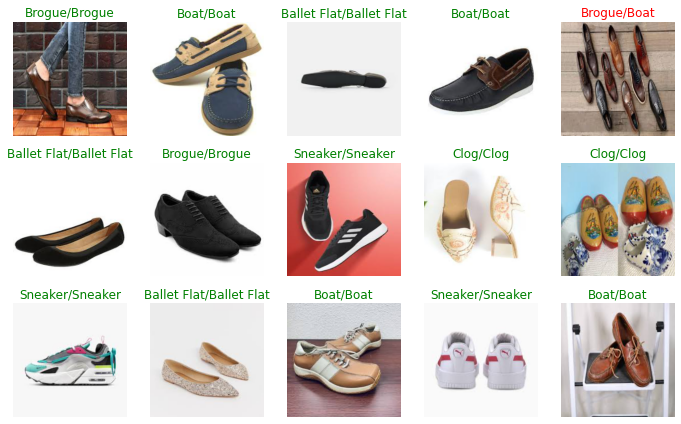

In [42]:
plot_predictions(model_o, dataloader, 3, 5)

## Resumen

En este post hemos visto como podemos llevar a cabo *transfer learning* con redes convolucionales. Aplicar esta técnica nos permitirá obtener mejores modelos con menos requisitos computacionales y con datasets reducidos. Podemos descargar una red pre-entrenada con otro dataset (idealmente, un dataset similar al nuestro) y aprovechar el máximo número de capas. Podemos *congelar* la red pre-entrenada, de manera que no se actualicen sus pesos durante el entrenamiento, y utilizarla solo como extractor de características que las nuevas capas (las cuales si entrenamos) pueden aprovechar. Aún así, hacer *fine tuning* (seguir entrenando la red pre-entrenada) puede dar como resultado un mejor modelo. El *transfer learning* es una técnica muy potente que siempre que podamos podemos aprovechar para reducir los requisitos computacionales de nuestros modelos.